Predictive analytics is a powerful approach for extracting insights from data and guiding data-informed decision-making. In this notebook, I delve into predictive analysis using a Instagram dataset as the foundation. My primary focus is on predicting "Engagements," a critical metric in the realm of social media. Engagements encompass various interactions with content, such as likes, shares, reactions, comments, and saves. These interactions signify how many individuals have not only viewed but actively engaged with the content. I leverage the carefully selected features retained throughout my analysis to achieve these predictions.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
path = "C:/Users/user/Downloads/DiceyTechHack"
data = pd.read_csv(path +"/InstagramData.csv")

In [3]:
data.head(2)

,Date,Content Type,Sent by,Post,Impressions,Reach,Engagement Rate (per Impression),Engagement Rate (per Reach),Engagements,Reactions,Comments,Saves,Video Views,Media Views,Organic Video Views,Tags
0,1/30/2023 17:06,Carousel,,The new Naira banknotes in circulation have se...,39681,32418,0.05,0.06,1942,1261,56,625,0,0,0,Other
1,4/15/2022 9:04,Photo,Blessing Ubah,We hope the faith that this #GoodFriday restor...,29186,25055,0.06,0.07,1763,709,1033,21,0,0,0,Other


In [4]:
data["Date"] = pd.to_datetime(data["Date"])
data["PostHour"] = data["Date"].dt.hour
data["PostMonth"] = data["Date"].dt.month_name()
data["PostYear"] = data["Date"].dt.year
data["num_post_words"] = data["Post"].str.len()

In [6]:
data["num_post_words"].fillna(0,inplace=True)

In [7]:
data.isnull().sum()

Date                                 0
Content Type                         0
Sent by                              0
Post                                11
Impressions                          0
Reach                                0
Engagement Rate (per Impression)     0
Engagement Rate (per Reach)          0
Engagements                          0
Reactions                            0
Comments                             0
Saves                                0
Video Views                          0
Media Views                          0
Organic Video Views                  0
Tags                                 0
PostHour                             0
PostMonth                            0
PostYear                             0
num_post_words                       0
dtype: int64

In [8]:
data.drop("Post", axis=1, inplace=True)
data.drop("Date", axis=1, inplace=True)

In [9]:
numeric_data = data.select_dtypes(include=[np.number])
cat_data = data.select_dtypes(exclude=[np.number])
print ("There are {} numeric and {} categorical columns in train data".format(numeric_data.shape[1],cat_data.shape[1]))

There are 14 numeric and 4 categorical columns in train data


In [10]:
corr = numeric_data.corr()
print(corr["Engagements"].sort_values(ascending = False))

Engagements                         1.000000
Reactions                           0.999451
Engagement Rate (per Impression)    0.290990
Video Views                         0.254964
Organic Video Views                 0.254964
Comments                            0.059364
Engagement Rate (per Reach)         0.058519
Impressions                         0.053875
Reach                               0.041740
PostYear                            0.040995
Saves                               0.037312
PostHour                           -0.009537
num_post_words                     -0.019369
Media Views                              NaN
Name: Engagements, dtype: float64


In [11]:
X = data.drop(["Engagements"],axis=1)
y = data["Engagements"]

In [12]:
from sklearn.preprocessing import LabelEncoder

In [13]:
le = LabelEncoder()

def processing_data(dataa):
     processed_data = data.copy()

     categ = ["Content Type",
              "Sent by",
              "Tags",
              "PostMonth"]
    
     for col in categ:
        processed_data[col] = le.fit_transform(processed_data[col])

     return pd.DataFrame(processed_data, columns = processed_data.columns) 

In [14]:
processed_X = processing_data(X)

In [15]:
processed_X.shape

(10000, 18)

In [16]:
processed_X.head(2)

,Content Type,Sent by,Impressions,Reach,Engagement Rate (per Impression),Engagement Rate (per Reach),Engagements,Reactions,Comments,Saves,Video Views,Media Views,Organic Video Views,Tags,PostHour,PostMonth,PostYear,num_post_words
0,0,0,39681,32418,0.05,0.06,1942,1261,56,625,0,0,0,69,17,4,2023,265.0
1,1,2,29186,25055,0.06,0.07,1763,709,1033,21,0,0,0,69,9,0,2022,101.0


In [17]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest,f_regression,mutual_info_regression,RFE
from sklearn.linear_model import LinearRegression,Lasso
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error

In [18]:
X_train,X_test,y_train,y_test = train_test_split(processed_X,y,test_size=0.2,random_state=42)

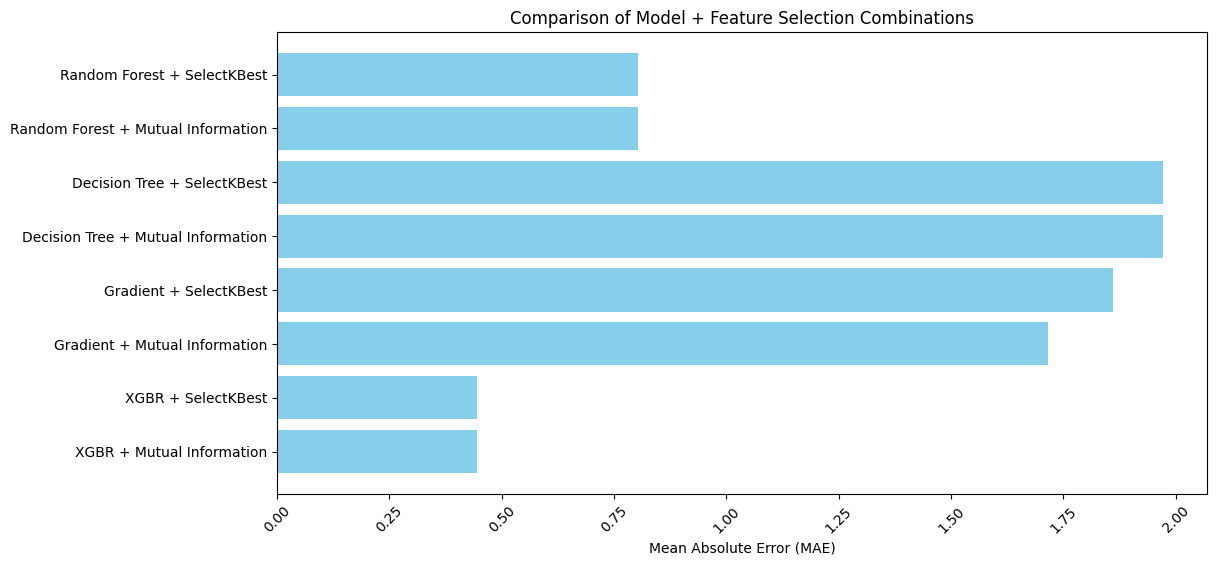

In [19]:
models = {
          "Random Forest":RandomForestRegressor(random_state=42),
          "Decision Tree":DecisionTreeRegressor(random_state=42),
          "Gradient":GradientBoostingRegressor(random_state=42),
          "XGBR":XGBRegressor(random_state=42)
          } 

methods = {
    'SelectKBest': SelectKBest(f_regression, k=15),
    'Mutual Information': SelectKBest(mutual_info_regression, k=15)
}

results = {}

for model_name, model in models.items():
    for method_name, method in methods.items():
        X_selected = method.fit_transform(X_train, y_train)
        X_test_selected = method.transform(X_test)
        
        model.fit(X_selected, y_train)
        y_pred = model.predict(X_test_selected)
        
        mae = mean_absolute_error(y_test, y_pred)
        results[f"{model_name} + {method_name}"] = mae

results_df = pd.DataFrame(list(results.items()), columns=['Combination', 'MAE'])

plt.figure(figsize=(12, 6))
plt.barh(results_df['Combination'], results_df['MAE'], color='skyblue')
plt.xlabel('Mean Absolute Error (MAE)')
plt.xticks(rotation=45)
plt.title('Comparison of Model + Feature Selection Combinations')
plt.gca().invert_yaxis()  # Invert the y-axis for better readability
plt.show()

In [20]:
k = 15
selector = SelectKBest(score_func=f_regression,k=k)
X_selected = selector.fit_transform(X_train,y_train)
X_test_selected = selector.transform(X_test)

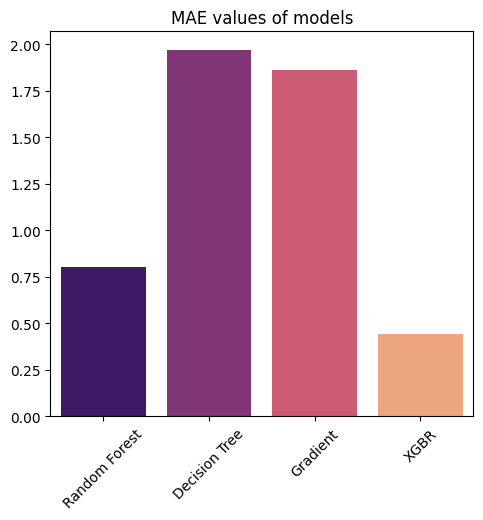

In [21]:
models = {
          "Random Forest":RandomForestRegressor(random_state=42),
          "Decision Tree":DecisionTreeRegressor(random_state=42),
          "Gradient":GradientBoostingRegressor(random_state=42),
          "XGBR":XGBRegressor(random_state=42)
          } 
mae_values= []

for name, model in models.items():
     model.fit(X_selected,y_train)
     preds = model.predict(X_test_selected)
     accuracy =mean_absolute_error(y_test,preds)
     mae_values.append(accuracy)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)

sns.barplot(x= list(models.keys()), y = mae_values, palette = "magma")
plt.title("MAE values of models")
plt.xticks(rotation=45)
plt.show()

In [22]:
dt = DecisionTreeRegressor()
dt.fit(X_selected,y_train)
y_pred = dt.predict(X_test_selected)
mae = mean_absolute_error(y_test,y_pred)
print(f"MAE of Random Forest is {mae:.4f}")

MAE of Random Forest is 1.6740
